In [1]:
import torch 
import torch.nn as nn
import torchio
import torchio.transforms as transforms
import torchvision.transforms as pytransforms

from captum.attr import visualization as viz
from captum.attr import (
    Occlusion,
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
    GuidedGradCam
)

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from PIL import Image

import os
import sys
sys.path.insert(0, '../../scripts/')
from helpers import miscellaneous as misc
from data_loader import get_data_loader
from torch.utils.data import DataLoader

from ml_models import get_model

CONFIG = misc.get_config()

TRANSFORMER = CONFIG['TRANSFORMER']
SLICE = CONFIG['NSLICE']
TEST_SET = '../../' + CONFIG['TEST_LABELS_DIR']
from helpers import preprocessing2d as prep
train_transform, test_transform = prep.get_transformer(TRANSFORMER)

# Load the ONNX model
# change this to different models
DIMENSION = 3
model_path = "../../scripts/DenseNet121-DIM3-model_final.pt"
model_checkpoint = torch.load(model_path, map_location=torch.device('cuda'))

model = get_model()
model.load_state_dict(model_checkpoint)

idx_to_labels = {
    0: "CN",
    1: "MCI",
    2: "AD"
}

In [2]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

#!python -m captum.insights.example

### Load sample image just like it is loaded into the model

In [3]:
from data_loader import get_data_loader
loader = get_data_loader()
val_set = loader(TEST_SET, transform=None, dimension=DIMENSION, nslice=SLICE)

#dataloader = DataLoader(val_set, batch_size=1, num_workers=1, shuffle=False)

batch = val_set.__getitem__(0)
img = batch['images']
label = batch['labels']
print(img.shape, label)

torch.Size([1, 256, 256]) 1


### might be good to implement a function to load sample iamges based on classes

In [ ]:
"""img_dir = '../../' + CONFIG['FLATTENED_DATA_DIR']
img_ids = os.listdir(img_dir)
img = torchio.ScalarImage(img_dir + img_ids[23])

def data_load(img):

    if SLICE == 'Center':
        nslice = img.data.size(DIMENSION)//2 #add more parameters for different slices, for example: 10%, 20%
    else:
        nslice = SLICE

    if SLICE:
        if DIMENSION == 1:
            assert img.data.size()[1] >= nslice, f'[WARN] Nslice is too large. Max allowed: {img.data.size()[1]}'
            img = img.data[:, nslice, :, :]
        elif DIMENSION == 2:
            assert img.data.size()[2] >= nslice, f'[WARN] Nslice is too large. Max allowed: {img.data.size()[2]}'
            img = img.data[:, :, nslice, :]
        elif DIMENSION == 3:
            assert img.data.size()[3] >= nslice, f'[WARN] Nslice is too large. Max allowed: {img.data.size()[3]}'
            img = img.data[:, :, :, nslice]
        
    print("image size before transform: ", img.shape)
    img = train_transform(img)
    print("image size after transform: ", img.shape)
    return img
    
img = data_load(img)        
plt.imshow(img.data[0,:,:], cmap="gray")
plt.show()"""

In [5]:
input_tensor = img.squeeze().unsqueeze(dim=0).unsqueeze(0)

### Gradcam using torchcam.methods

(couldn't make the overlay_mask() to work with the original image on top of the gradcam)

In [6]:
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import normalize, resize, to_pil_image

cam_extractor = SmoothGradCAMpp(model, target_layer=[model.features[-1]])

# Preprocess your data and feed it to the model
out = model(input_tensor)

# Retrieve the CAM by passing the class index and the model output
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

# Resize the CAM and overlay it
result = overlay_mask(to_pil_image(img.squeeze(), mode="F"), to_pil_image(activation_map[0].numpy()), alpha=0.5)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

ValueError: operands could not be broadcast together with shapes (256,256) (256,256,3) 

### Without overlaying the images, just the images above one another:

In [ ]:
plt.imshow(activation_map[0].squeeze(0).numpy())
plt.axis('off')
plt.tight_layout()
plt.show()
plt.imshow(to_pil_image(img))

### Whats the actual prediction of the image vs. actual class?

In [8]:
prediction_score, pred_label_idx = torch.topk(out, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[pred_label_idx.item()]
actual_label = idx_to_labels[label]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')
print('Actual Class:', actual_label)

Predicted: MCI ( 0.722634494304657 )
Actual Class: MCI


### Integrated Gradients

Predicted: MCI ( 0.722634494304657 )
Actual Class: MCI
(256, 256, 1)
(256, 256, 1)


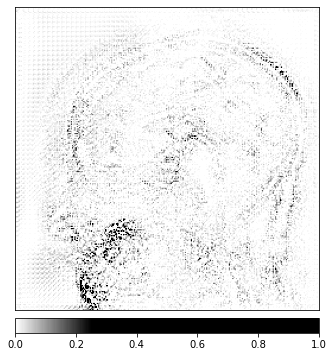

CPU times: total: 45 s
Wall time: 8.36 s


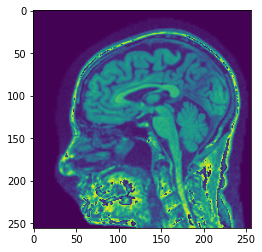

In [9]:
%%time
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')
print('Actual Class:', actual_label)

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input_tensor, target=pred_label_idx, n_steps=20)

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)
print(attributions_ig.squeeze().unsqueeze(dim=2).cpu().detach().numpy().shape)
print(img.squeeze().unsqueeze(dim=2).cpu().detach().numpy().shape)
_ = viz.visualize_image_attr(attributions_ig.squeeze().unsqueeze(dim=2).cpu().detach().numpy(),
                             img.squeeze().unsqueeze(dim=2).cpu().detach().numpy(),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

plt.imshow(to_pil_image(img))

## Noise Tunnel

In [10]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input_tensor, nt_samples=2, nt_type='smoothgrad_sq', target=pred_label_idx)

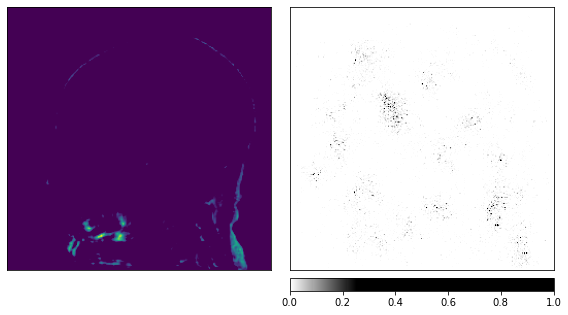

In [11]:
_ = viz.visualize_image_attr_multiple(attributions_ig_nt.squeeze().unsqueeze(dim=2).cpu().detach().numpy(),
                                      img.squeeze().unsqueeze(dim=2).cpu().detach().numpy(),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

## Gradient Shapley

<Figure size 1280x800 with 0 Axes>

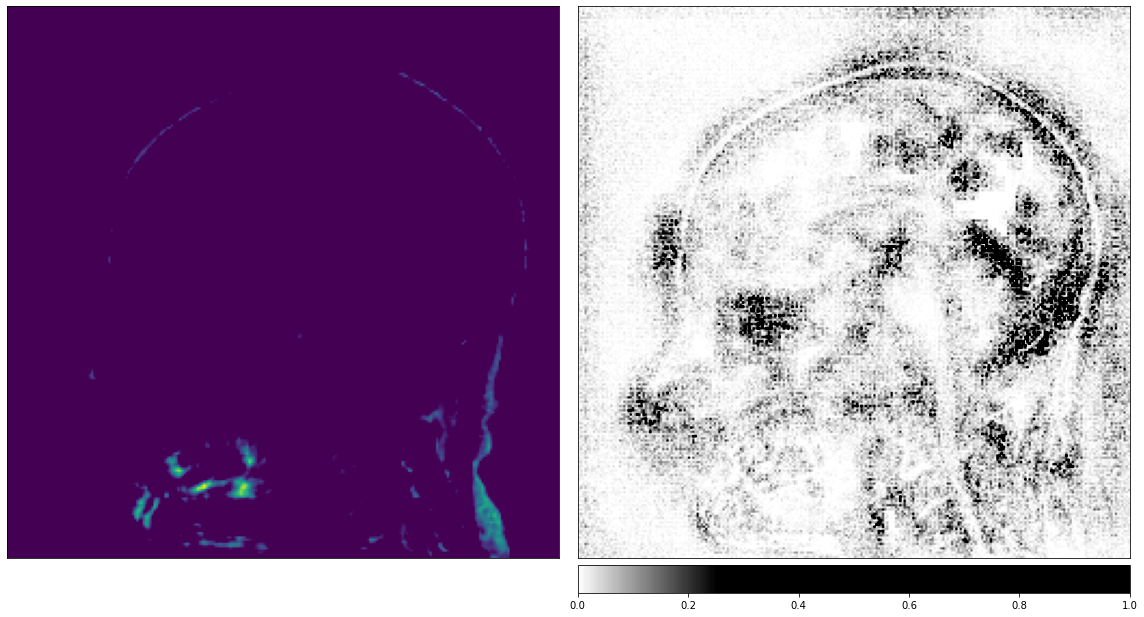

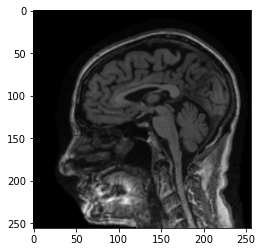

In [12]:
figure(figsize=(16, 10), dpi=80)

torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input_tensor * 0, input_tensor * 1])

attributions_gs = gradient_shap.attribute(input_tensor,
                                          n_samples=1,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(attributions_gs.squeeze().unsqueeze(dim=2).cpu().detach().numpy(),
                                      img.squeeze().unsqueeze(dim=2).cpu().detach().numpy(),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True,
                                     fig_size=(16,12))

plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Guided Gradcam 

Layer can be chosen and it usually applied to the last convolutional layer. 

more: https://captum.ai/api/guided_grad_cam.html 

The following example shows the guided gradcam of the complete last dense layer for the class 2 (Alzheimer) as selected in "guided_gc.attribute(input_tensor, 2)" with the second parameter:

In [13]:
model.features[-2][-1]

_DenseLayer(
  (layers): Sequential(
    (norm1): BatchNorm2d(992, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv1): Conv2d(992, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
)

C:\Users\bruno\anaconda3\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
C:\Users\bruno\anaconda3\lib\site-packages\captum\attr\_core\guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


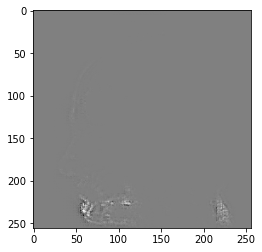

In [14]:
model.eval()

mod = nn.Sequential(model.features, nn.ReLU(), nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(1))

test = torch.clone(input_tensor)

out = model(test)

for i, (name, layer) in enumerate(model.named_modules()):
    layer.inplace = False

guided_gc = GuidedGradCam(mod, model.features[-2][-1])
attribution = guided_gc.attribute(input_tensor, 2)

plt.imshow(attribution.detach().numpy().squeeze(), cmap="gray")

Same thing for the class MCI:

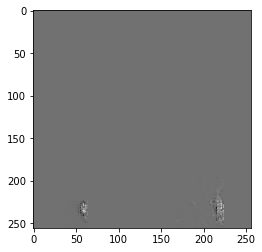

In [15]:
attribution = guided_gc.attribute(input_tensor, 1)

plt.imshow(attribution.detach().numpy().squeeze(), cmap="gray")

Same thing for class Control Group:

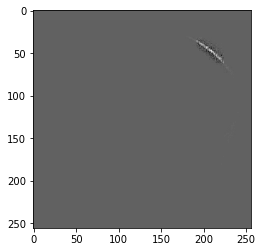

In [16]:
attribution = guided_gc.attribute(input_tensor, 0)

plt.imshow(attribution.detach().numpy().squeeze(), cmap="gray")

In [22]:
def hook_g(m, input, output): print(input.shape)
model.features[0].register_full_backward_hook(hook_g)

## Occlusion

In [23]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input_tensor,
                                       strides = (1, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(1,15, 15),
                                       baselines=0)

RuntimeError: cannot register a hook on a tensor that doesn't require gradient

In [26]:
visualisation = {}

def hook_fn(m, i, o):
    visualisation[m] = o 

def get_all_layers(net):
    for name, layer in net._modules.items():
        #If it is a sequential, don't register a hook on it
        # but recursively register hook on all it's module children
        if isinstance(layer, nn.Sequential):
            get_all_layers(layer)
        else:
          # it's a non sequential. Register a hook
          layer.register_forward_hook(hook_fn)

get_all_layers(model)
  
out = model(input_tensor)

occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input_tensor,
                                       strides = (1, 4, 4),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(1,15, 15),
                                       baselines=0)

# Just to check whether we got all layers
#visualisation.keys()

RuntimeError: cannot register a hook on a tensor that doesn't require gradient